# MultilayerPy - crash course (version 0.0.1)

This is a rough guide to get MultilayerPy working on your machine. It will reproduce the output (roughly) from the KM-SUB description paper Fig. 2(a) (https://doi.org/10.5194/acp-10-3673-2010).

#### List of things to setup before starting:
1. Import the MultilayerPy folder to where you want to test the package (I'll send it as a .zip to you). Maybe a "model_builder" folder...
2. Open up a session in Spyder (if you don't have spyder, download Anaconda and open it from there). 
3. Open the example.py file. I have left comments in that file to prompt you where to write different parts of the code. 
4. Make sure you have scipy and numpy installed. Check this by tring to run `import scipy` and `import numpy` in the ipython console window. If you don't have those: `pip install scipy` and/or `pip install numpy` should do it.

First of all we need to import all of the packages that we need. This is already done in the example.py file. This also imports the `kmsub_model_build` and `simulate` files that are the basis of the package. I will rename `kmsub_model_build` in the future as there will be more than just KM-SUB.

In [1]:
# importing the necessaries
import numpy as np
import kmsub_model_build 
import simulate 
import scipy

### Defining the reaction scheme
The first thing to do is define the reaction scheme. In this case, **oleic acid + ozone --> products**. There are 3 components. 

To define the reaction scheme, a `reactant_tuple_list` and `product_tuple_list` is defined. These two objects are lists of tuples (tuple: `(a,b)`; list of tuples:`[(a,b), (c,d)]`). Each member of the list (tuple) represents reactants/product(s) of that reaction. **Both tuple lists need to be in the same order as the reaction scheme; i.e. reaction 2 needs to be after reaction 1 etc.**

In this simple case, there is only one reaction with 2 reactants and 1 product. All you need to do is assign a number to each of these. Here: oleic acid = 1, ozone = 2, products = 3.

Now we can build up the reaction scheme using the `ReactionScheme` object in MultilayerPy:

In [2]:
# build the reaction tuple list, in this case only 1 tuple in the list (for 1 reaction)
# component 1 (oleic acid) reacts with component 2 (ozone)
reaction_tuple_list = [(1,2)]

# build the product tuple list, only component 3 (products) is a product
# a tuple with a single value inside is defined (value,)
product_tuple_list = [(3,)]

# now construct the reaction scheme
# we can give it a name and define the nuber of components as below
reaction_scheme = kmsub_model_build.ReactionScheme(name='Oleic acid ozonolysis',
                                                   n_components=3,
                                                   reaction_tuple_list=reaction_tuple_list,
                                                products_of_reactions_list=product_tuple_list)

# let's print out a representation of the reaction scheme
reaction_scheme.display()

#########################################################
Reaction scheme: Oleic acid ozonolysis
** No stoichiometry shown **
R1: 1 + 2 -----> 3 
#########################################################


### Model components
Now we need to make the model components. This is done using the `ModelComponent` object in MultilayerPy. This needs to be supplied with the component number and reaction scheme. Optionally, we can give it a name. 

In [3]:
# making model components

# oleic acid
OA = kmsub_model_build.ModelComponent(1,reaction_scheme,name='Oleic acid')

# ozone, declare that it is a gas
O3 = kmsub_model_build.ModelComponent(2,reaction_scheme,gas=True,name='Ozone') 

# products
prod = kmsub_model_build.ModelComponent(3,reaction_scheme, name='Reaction products')

# collect into a dictionary
model_components_dict = {'1':OA,
                        '2':O3,
                        '3':prod}

### Diffusion 
This simple example does not consider diffusion as a function of particle composition. MultilayerPy does, however, have the capacity to account for this. 

We still need to declare that there is no diffusion evolution. A more detailed example of how to account for diffusion evolution will be provided in the future. 

Here, we will supply a Python dictionary with keys representing components and values of `None`, meaning there is no diffusion evolution. This is then fed into the `DiffusionRegime` object, which writes the code necessary to define diffusion for each component.

In [4]:
# making the diffusion dictionary
diff_dict = {'1' : None,
             '2': None,
             '3':None}  

# make diffusion regime
diff_regime = kmsub_model_build.DiffusionRegime(model_components_dict,diff_dict=diff_dict)

# call it to build diffusion code ready for the builder
diff_regime()


### Construct the model
Now we can construct the model using `ModelBuilder` in MultilayerPy. This requires the `reaction_scheme`, `model_components_dict` and `diff_regime` defined earlier.

*slight artifact at the moment, redundant arguments are also supplied to the builder. Will remove this soon.*

In [5]:
# create the model object, ignore [1,2,3] etc at the end
model = kmsub_model_build.ModelBuilder(reaction_scheme,model_components_dict,diff_regime,[1,2,3],[3,2,1],
                                 100)

# build the model. Will save a file, don't include the date in the model filename
model.build(date=False)

# print out the parameters required for the model to run
print(model.req_params)

{'T', 'Db_2', 'Td_2', 'k_1_2', 'k_1_2_surf', 'delta_1', 'Db_1', 'w_2', 'H_2', 'alpha_s_0_2', 'delta_3', 'delta_2', 'Db_3', 'Xgs_2'}


### Running the model
Models are run using the `Simulate` object in MultilayerPy. 

The required parameters need to be supplied as a dictionary. I am working on getting the user to supply a spreadsheet/.csv file with this information for easier usability. For the moment, I have made a dictionary.

A description of each parameter will be supplied separately in the documentation. 

All we need to do is supply: 
* the parameter dictionary
* number of model layers
* radius of the particle/thickness of the film
* time span to run the model
* number of timepoints to save
* Volume and surface area of each model layer
* Initial concentrations of every component in the film

**This is currently the most involved part of things. I have ideas for making this easier in the future.**


Model run took 13.12 s


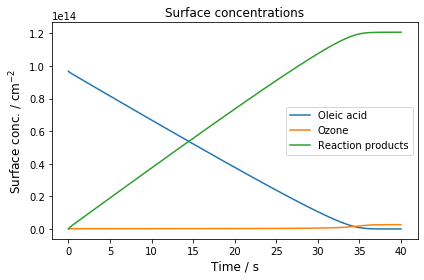

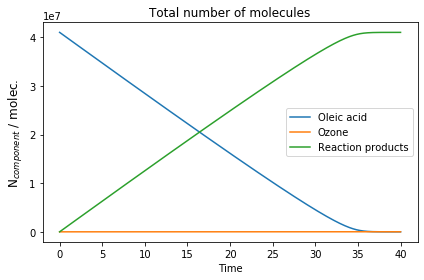

In [6]:
# make the parameter dictionary
# these are parameters from the KM-SUB paper
param_dict = {'delta_3':1e-7,
              'alpha_s_0_2':4.2e-4,
              'kd_X_2':1/1e-2,
              'delta_2':0.4e-7,
              'Db_2':1e-5,
              'delta_1':0.8e-7,
              'Db_1':1e-10,
              'Db_3':1e-10,
              'k_1_2':1.7e-15,
              'H_2':4.8e-4,
              'Xgs_2': 7.0e13,
              'Td_2': 1e-2,
              'w_2':3.6e4,
              'T':298,
              'k_1_2_surf':6.0e-12}

# make the simulate object with the model and parameter dictionary
sim = simulate.Simulate(model,param_dict)

# define required parameters
n_layers = 100
rp = 0.2e-4 # radius in cm
time_span = [0,40] # in s
n_time = 999

#spherical V and A

delta = rp/n_layers # thickness of each layer

V = np.zeros(n_layers)
A = np.zeros(n_layers)
for i in np.arange(n_layers):
    layerno = i + 1
    V[i] = (4/3) * np.pi * ((rp-(layerno-1)*delta)**3 - (rp-layerno*delta)**3)    
    A[i] = 4 * np.pi * (rp-(layerno-1)*delta)**2

layer_thick = np.ones(n_layers) * delta

# initial conc. of everything
y0=np.zeros(n_layers * 3 + 3)

y0[0] = 9.68e13 # surf conc of oleic acid
for i in np.arange(1,n_layers+1):
    y0[i] = 1.21e21 # bulk conc of oleic acid
    
# now run the model
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)

%matplotlib inline
# plot the model
sim.plot()

In [7]:
sim.run_params

{'n_layers': 100,
 'rp': 2e-05,
 'time_span': [0, 40],
 'n_time': 999,
 'V': array([9.95290063e-16, 9.75384932e-16, 9.55680863e-16, 9.36177856e-16,
        9.16875910e-16, 8.97775027e-16, 8.78875206e-16, 8.60176446e-16,
        8.41678749e-16, 8.23382113e-16, 8.05286539e-16, 7.87392028e-16,
        7.69698578e-16, 7.52206190e-16, 7.34914864e-16, 7.17824600e-16,
        7.00935398e-16, 6.84247258e-16, 6.67760179e-16, 6.51474163e-16,
        6.35389209e-16, 6.19505316e-16, 6.03822486e-16, 5.88340717e-16,
        5.73060010e-16, 5.57980366e-16, 5.43101783e-16, 5.28424262e-16,
        5.13947803e-16, 4.99672406e-16, 4.85598071e-16, 4.71724798e-16,
        4.58052586e-16, 4.44581437e-16, 4.31311350e-16, 4.18242324e-16,
        4.05374361e-16, 3.92707459e-16, 3.80241620e-16, 3.67976842e-16,
        3.55913126e-16, 3.44050472e-16, 3.32388880e-16, 3.20928350e-16,
        3.09668882e-16, 2.98610476e-16, 2.87753132e-16, 2.77096850e-16,
        2.66641629e-16, 2.56387471e-16, 2.46334374e-16, 2.36